<a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/Semana5_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerías

En esta celda se instalan las dependencias necesarias tanto a nivel del sistema como de Python para poder utilizar algunos entornos de Gymnasium con MuJoCo, así como herramientas de visualización y aprendizaje por refuerzo. Específicamente, se instalarán un par de entornos de MuJoCo que requieren soporte de renderizado, por lo que se incluye la configuración de xvfb, ffmpeg y otras librerías necesarias para que funcionen correctamente en el entorno de Google Colab.

In [ ]:
# Instalación de dependencias del sistema
!apt update -y > /dev/null
!apt install -y xvfb ffmpeg > /dev/null

# Instalación de paquetes de Python
!pip install gymnasium[mujoco] pyvirtualdisplay imageio[ffmpeg] stable-baselines3 -q

# Importación de librerías necesarias
from pyvirtualdisplay import Display
from IPython.display import HTML
from base64 import b64encode

import gymnasium as gym
import imageio
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from stable_baselines3 import SAC, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

#Limpia los registros generados
from IPython.display import clear_output
clear_output()
print("Todas las librerías y dependencias han sido instaladas correctamente.")

Todas las librerías y dependencias han sido instaladas correctamente.


# Hopper


## Familiarización con el entorno

In [ ]:
# Start a virtual display (needed in Colab or headless)
display = Display(visible=0, size=(1400, 900))
display.start()

# Create Hopper environment with RGB rendering
env = gym.make("Hopper-v5", render_mode="rgb_array")
obs, info = env.reset()

frames = []
terminated = truncated = False
total_reward = 0

while not (terminated or truncated):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    total_reward += reward

env.close()

# Save video
imageio.mimsave("hopper_video.mp4", frames, fps=30)
print("Total reward:", total_reward)


Total reward: 16.246963524749546


In [ ]:
mp4 = open("/content/hopper_video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")


## Entrenamiento de modelos de RL

### Clase encargada para el entrenamiento de los modelos para Hopper

In [ ]:
class RewardLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.episode_reward = 0

    def _on_step(self) -> bool:
        if "rewards" in self.locals:
            self.episode_reward += self.locals["rewards"][0]
        if "dones" in self.locals and self.locals["dones"][0]:
            self.episode_rewards.append(self.episode_reward)
            self.episode_reward = 0
        return True


class HopperTrainer:
    def __init__(self, model_fn, total_timesteps=130_000, log_dir="./hopper_logs"):
        self.total_timesteps = total_timesteps
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

        # Virtual display
        self.display = Display(visible=0, size=(1400, 900))
        self.display.start()

        # Create environment
        self.env = make_vec_env("Hopper-v5", n_envs=1)

        # Create model using the provided function
        self.model = model_fn(self.env)

        # Reward logging
        self.callback = RewardLoggerCallback()


    def train(self, save_path="sac_hopper_model"):
        print("GPU available?", torch.cuda.is_available())
        if torch.cuda.is_available():
            print("Using device:", torch.cuda.get_device_name(0))

        start_time = time.time()
        self.model.learn(total_timesteps=self.total_timesteps, callback=self.callback)
        elapsed = time.time() - start_time

        self.model.save(save_path)
        print(f"Training complete. Model saved. Training took {elapsed:.2f} seconds.")

    def plot_rewards(self):
        if not self.callback.episode_rewards:
            print("No reward data to plot.")
            return
        plt.figure(figsize=(10, 5))
        plt.plot(self.callback.episode_rewards, label="Episode Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Training Rewards Over Time")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_video(self, model, video_filename="hopper_video.mp4"):
        env = gym.make("Hopper-v5", render_mode="rgb_array")
        obs, info = env.reset()
        frames = []
        total_reward = 0
        terminated = truncated = False

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            frame = env.render()
            frames.append(frame)
            total_reward += reward

        env.close()

        # Save video
        imageio.mimsave(video_filename, frames, fps=30)
        print("Total reward:", total_reward)

        # Display video in Colab
        mp4 = open(video_filename, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)




### SAC

In [ ]:
def create_model(env):
    return SAC(
        "MlpPolicy",
        env,
        verbose=1,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

trainer = HopperTrainer(model_fn=create_model, total_timesteps=70_000)
trainer.train()

Using cuda device
GPU available? True
Using device: Tesla T4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 25.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1939     |
|    time_elapsed    | 0        |
|    total_timesteps | 100      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 18.2     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 203      |
|    time_elapsed    | 0        |
|    total_timesteps | 155      |
| train/             |          |
|    actor_loss      | -4.61    |
|    critic_loss     | 1.6      |
|    ent_coef        | 0.984    |
|    ent_coef_loss   | -0.08    |
|    learning_rate   | 0.0003   |
|    n_updates       | 54       |
---------------------------------
---------------------

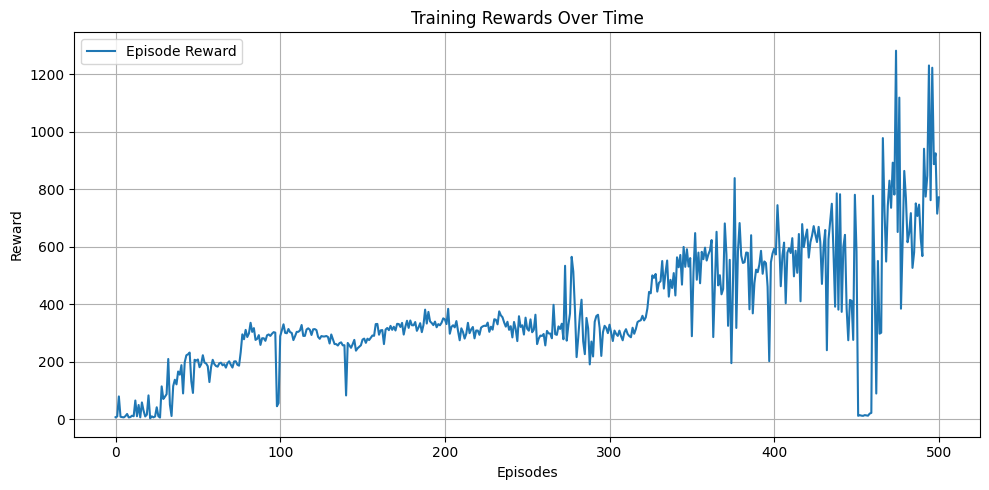

Total reward: 784.082602095408


In [ ]:
trainer.plot_rewards()
model = SAC.load("sac_hopper_model")
trainer.generate_video(model,video_filename='sac_hopper_video.mp4')

### A2C Intento 1

In [ ]:
def create_model(env):
    return A2C(
        "MlpPolicy",
        env,
        verbose=1,
        device="cpu"
    )

trainer = HopperTrainer(model_fn=create_model, total_timesteps=400_000)
trainer.train(save_path='a2c_hopper_model')

Streaming output truncated to the last 5000 lines.
|    fps                | 592      |
|    iterations         | 52300    |
|    time_elapsed       | 441      |
|    total_timesteps    | 261500   |
| train/                |          |
|    entropy_loss       | -2.65    |
|    explained_variance | -132     |
|    learning_rate      | 0.0007   |
|    n_updates          | 52299    |
|    policy_loss        | -34.4    |
|    std                | 0.608    |
|    value_loss         | 178      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 42.9     |
|    ep_rew_mean        | 70       |
| time/                 |          |
|    fps                | 592      |
|    iterations         | 52400    |
|    time_elapsed       | 441      |
|    total_timesteps    | 262000   |
| train/                |          |
|    entropy_loss       | -2.66    |
|    explained_variance | -2.05    |
|    learning_rate      

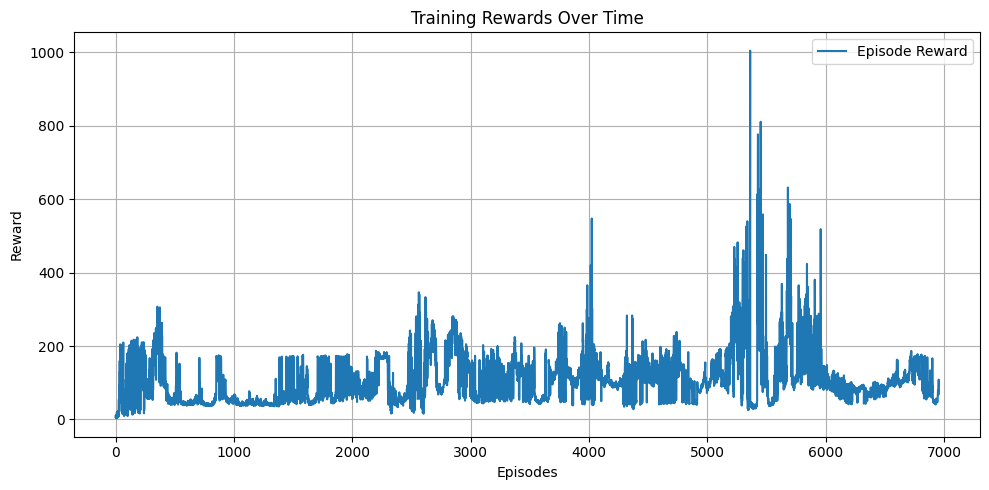

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Total reward: 87.73015747867703


In [ ]:
trainer.plot_rewards()
model = A2C.load("a2c_hopper_model")
trainer.generate_video(model,video_filename='a2c_hopper_video.mp4')

### A2C Intento 2

In [ ]:
def create_model(env):
    return A2C(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=7e-4,
        gamma=0.99,
        gae_lambda=0.95,
        n_steps=20,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        use_rms_prop=True,
        normalize_advantage=True,
        device="cpu",
        policy_kwargs=dict(
            net_arch=dict(pi=[64, 64], vf=[64, 64]),
            log_std_init=-1.0
        )
    )


trainer = HopperTrainer(model_fn=create_model, total_timesteps=400_000)
trainer.train(save_path='a2c_hopper_model')

Using cpu device
GPU available? True
Using device: Tesla T4
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 85.6     |
|    ep_rew_mean        | 171      |
| time/                 |          |
|    fps                | 705      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.24    |
|    explained_variance | -0.00569 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.191   |
|    std                | 0.366    |
|    value_loss         | 220      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 90.4     |
|    ep_rew_mean        | 186      |
| time/                 |          |
|    fps                | 794      |
|    iterations         | 200      |
|    time_elaps

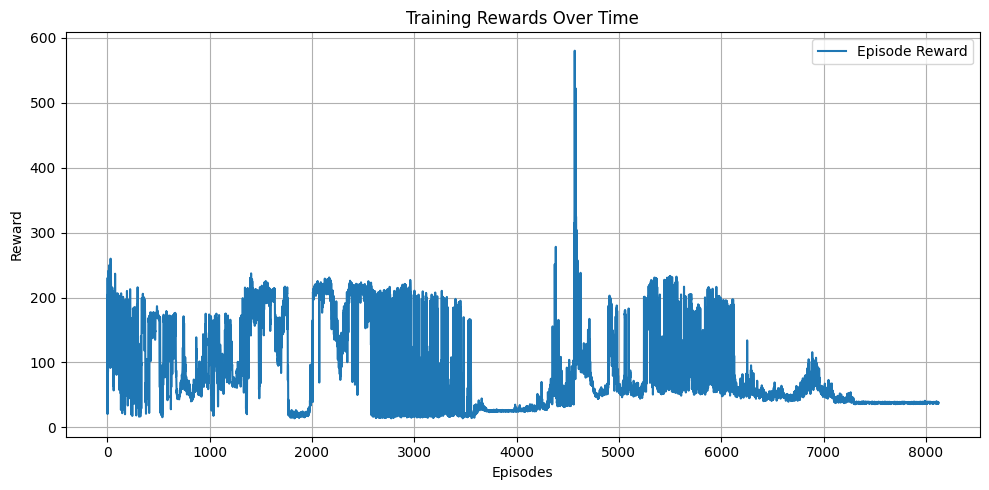

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Total reward: 39.210824438431416


In [ ]:
trainer.plot_rewards()
model = A2C.load("a2c_hopper_model")
trainer.generate_video(model,video_filename='a2c_hopper_video.mp4')

### Resumen de los resultados

In [ ]:
import pandas as pd

data = {
    'Algorithm': ['SAC', 'A2C Intento 1','A2C Intento 2'],
    'Training Time (s)': [953.40, 677.04,448.92],
    'Average Reward': [583, 71.9,38.1],
    'Training timesteps': [70000, 400000,400000]
}

df = pd.DataFrame(data)
df

Algorithm  Training Time (s)  Average Reward  Training timesteps
0            SAC             953.40           583.0               70000
1  A2C Intento 1             677.04            71.9              400000
2  A2C Intento 2             448.92            38.1              400000

# Ant

## Familiarización con el entorno

In [ ]:
# Start a virtual display (needed in Colab or headless)
display = Display(visible=0, size=(1400, 900))
display.start()

# Create Ant environment with RGB rendering
env = gym.make("Ant-v5", render_mode="rgb_array")
obs, info = env.reset()

frames = []
terminated = truncated = False
total_reward = 0

while not (terminated or truncated):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    total_reward += reward

env.close()

# Save video
imageio.mimsave("ant_video.mp4", frames, fps=30)
print("Total reward:", total_reward)


Total reward: -21.095171476704824


In [ ]:
mp4 = open("/content/ant_video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

## Entrenamiento de modelos de RL

### Clase encargada para el entrenamiento de los modelos para Hopper

In [ ]:
class AntTrainer:
    def __init__(self, model_fn, total_timesteps=130_000, log_dir="./ant_logs"):
        self.total_timesteps = total_timesteps
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

        # Virtual display
        self.display = Display(visible=0, size=(1400, 900))
        self.display.start()

        # Create environment
        self.env = make_vec_env("Ant-v5", n_envs=1)

        # Create model using the provided function
        self.model = model_fn(self.env)

        # Reward logging
        self.callback = RewardLoggerCallback()

    def train(self, save_path="sac_ant_model"):
        print("GPU available?", torch.cuda.is_available())
        if torch.cuda.is_available():
            print("Using device:", torch.cuda.get_device_name(0))

        start_time = time.time()
        self.model.learn(total_timesteps=self.total_timesteps, callback=self.callback)
        elapsed = time.time() - start_time

        self.model.save(save_path)
        print(f"Training complete. Model saved. Training took {elapsed:.2f} seconds.")

    def plot_rewards(self):
        if not self.callback.episode_rewards:
            print("No reward data to plot.")
            return
        plt.figure(figsize=(10, 5))
        plt.plot(self.callback.episode_rewards, label="Episode Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Training Rewards Over Time")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_video(self, model, video_filename="ant_video.mp4"):
        env = gym.make("Ant-v5", render_mode="rgb_array")
        obs, info = env.reset()
        frames = []
        total_reward = 0
        terminated = truncated = False

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            frame = env.render()
            frames.append(frame)
            total_reward += reward

        env.close()

        # Save video
        imageio.mimsave(video_filename, frames, fps=30)
        print("Total reward:", total_reward)

        # Display video in Colab
        mp4 = open(video_filename, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)

### SAC

In [ ]:
def create_model(env):
    return SAC(
        "MlpPolicy",
        env,
        verbose=1,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

trainer = AntTrainer(model_fn=create_model, total_timesteps=100_000)
trainer.train()

Using cuda device
GPU available? True
Using device: Tesla T4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 83       |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 100      |
|    time_elapsed    | 3        |
|    total_timesteps | 332      |
| train/             |          |
|    actor_loss      | -13.1    |
|    critic_loss     | 1.86     |
|    ent_coef        | 0.933    |
|    ent_coef_loss   | -0.924   |
|    learning_rate   | 0.0003   |
|    n_updates       | 231      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 229      |
|    ep_rew_mean     | -95.6    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 75       |
|    time_elapsed    | 24       |
|    total_timesteps | 1835     |
| train/             |          |
|    actor_loss      

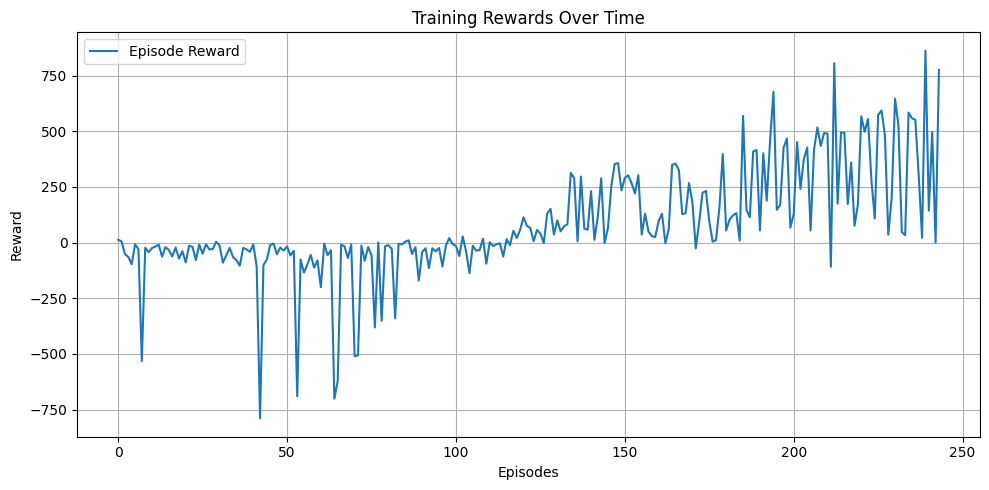

Total reward: 169.74719632982328


In [ ]:
trainer.plot_rewards()
model = SAC.load("sac_ant_model")
trainer.generate_video(model,video_filename='sac_ant_video.mp4')

### A2C

In [ ]:
def create_model(env):
    return A2C(
        "MlpPolicy",
        env,
        verbose=1,
        device="cpu"
    )

trainer = AntTrainer(model_fn=create_model, total_timesteps=400_000)
trainer.train(save_path='a2c_ant_model')

Streaming output truncated to the last 5000 lines.
|    fps                | 486      |
|    iterations         | 52300    |
|    time_elapsed       | 537      |
|    total_timesteps    | 261500   |
| train/                |          |
|    entropy_loss       | 8.59     |
|    explained_variance | -19.8    |
|    learning_rate      | 0.0007   |
|    n_updates          | 52299    |
|    policy_loss        | -1.77    |
|    std                | 0.083    |
|    value_loss         | 0.0735   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 790      |
|    ep_rew_mean        | 568      |
| time/                 |          |
|    fps                | 486      |
|    iterations         | 52400    |
|    time_elapsed       | 538      |
|    total_timesteps    | 262000   |
| train/                |          |
|    entropy_loss       | 8.56     |
|    explained_variance | 0.398    |
|    learning_rate      

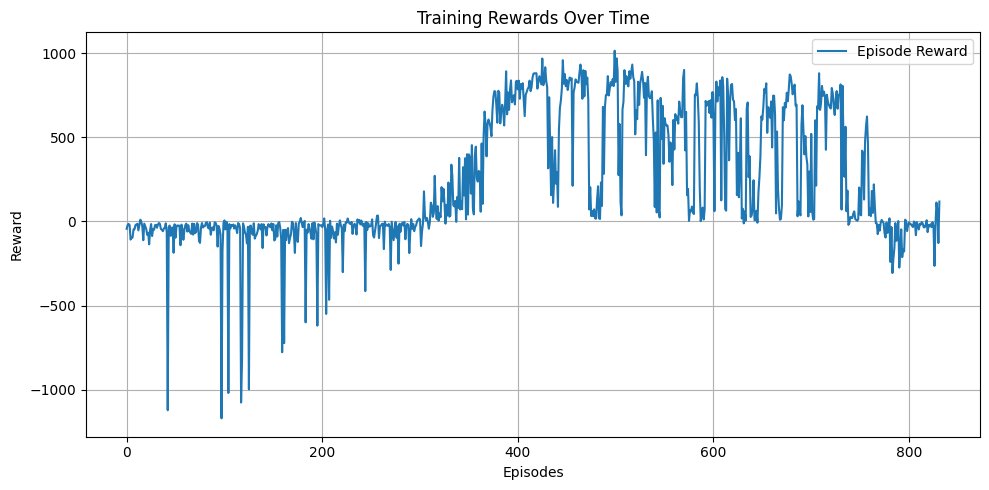

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Total reward: 23.896003273195674


In [ ]:
trainer.plot_rewards()
model = A2C.load("a2c_ant_model")
trainer.generate_video(model,video_filename='a2c_ant_video.mp4')

### Resumen de los resultados

In [ ]:
data = {
    'Algorithm': ['SAC', 'A2C'],
    'Training Time (s)': [1390.33, 821.46],
    'Average Reward': [274, 31.7],
    'Training timesteps': [100000, 400000]
}

df = pd.DataFrame(data)
df

Algorithm  Training Time (s)  Average Reward  Training timesteps
0       SAC            1390.33           274.0              100000
1       A2C             821.46            31.7              400000